In [1]:
import os 
import glob
import numpy as numpy
import pandas as pd 
import matplotlib.pyplot as plt 


# DaLiA Dataset

In [ ]:
data_path = "C:/Users/cleme/ETH/Master/Thesis/data/DaLiA/data/PPG_FieldStudy"
participant_paths = glob.glob(os.path.join(data_path, '**', '*_quest.csv'), recursive=True)
series = []
for participant in participant_paths:
   row = pd.read_csv(participant, header=None).T
   row.columns = [el.split(" ")[1] for el in row.iloc[0]]
   row = row.drop(row.index[0])
   series.append(row) 

df = pd.concat(series, ignore_index=True)
df

,SUBJECT_ID,AGE,GENDER,HEIGHT,WEIGHT,SKIN,SPORT
0,S1,34,m,182,78,3,6
1,S10,55,f,164,56,4,5
2,S11,24,f,168,62,3,5
3,S12,43,m,195,105,3,5
4,S13,21,f,170,63,3,6
5,S14,26,f,170,67,3,4
6,S15,28,m,183,79,2,5
7,S2,28,m,189,80,3,5
8,S3,25,m,170,60,3,5
9,S4,25,m,168,57,4,5


<Axes: >

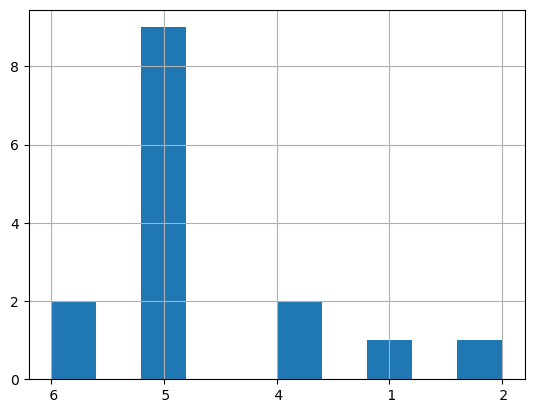

In [13]:
df["SPORT"].hist()